## DEFINED MY ON CHATBOT FROM THE PREVIOUS EXAMPLE WITH AN EXTERNAL DATABASE CHECKPOINTER

In [1]:
# Cell 1: Environment Setup
import os, getpass

def _configure_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_configure_env("OPENAI_API_KEY")



In [2]:
# Cell 2: LangSmith Configuration
_configure_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"



In [3]:
# Cell 3: Initialize LLM
# We'll use LangSmith for tracing
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)



/Users/rishitkamboj/College/langschain course /.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [4]:
# Cell 4: Import Message Classes and Define State
# Import necessary modules for message handling
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str



In [5]:
# Cell 5: Define Model Invocation Node
# Define the logic to call the model
def invoke_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")
    
    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        sys_msg = f"Summary of conversation earlier: {summary}\n\n"
        
        # Append summary to any newer messages
        msgs = [SystemMessage(content=sys_msg)] + state["messages"]
    
    else:
        msgs = state["messages"]
    
    result = llm.invoke(msgs)
    return {"messages": result}



In [6]:
# Cell 6: Define Summary Generation Node
# We'll define a node to produce a summary
def generate_summary(state: State):
    
    # First, we get the summary
    summary = state.get("summary", "")
    
    # Create our summarization prompt
    if summary:
        
        # If summary already exists
        summary_msg = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_msg = "Create a summary of the conversation above."
    
    # Add prompt to our history
    msgs = state["messages"] + [HumanMessage(content=summary_msg)]
    result = llm.invoke(msgs)
    
    # Delete all but the 2 most recent messages
    remove_msgs = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": result.content, "messages": remove_msgs}



In [ ]:
# Cell 7: Define Conditional Logic
# We'll add a conditional edge to determine whether to produce a summary based on the conversation length
from langgraph.graph import END
from typing_extensions import Literal

def check_continuation(state: State) -> Literal["summarize_conversation", END]: 
    """Return the next node to execute."""
    
    msgs = state["messages"]
    
    # If there are more than 4 messages, then we generate the summary
    if len(msgs) > 4:
        return "summarize_conversation" # <-- FIX: This string must match the node name from Cell 8
    
    # Otherwise we can just end
    return END


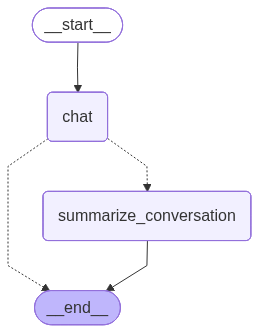

In [8]:
# Cell 8: Build the Graph with SQLite Checkpointer
# Adding memory section with SQLite for persistence
from IPython.display import Image, display
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START

# Here is our checkpointer with SQLite
import sqlite3

# Supply "memory" to create an in-memory SQLite database
conn = sqlite3.connect(":memory:", check_same_thread=False)

# But if we supply a db path, then it will create a database for us!
# mkdir -p state_db && if ! state_db/example.db; then echo "state_db/example.db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db"; fi

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

# Here is our checkpointer
memory = SqliteSaver(conn)

# Define a new graph
wflow = StateGraph(State)
wflow.add_node("chat", invoke_model)
wflow.add_node("summarize_conversation", generate_summary)

# Set the entrypoint as chat
wflow.add_edge(START, "chat")
wflow.add_conditional_edges("chat", check_continuation)
wflow.add_edge("summarize_conversation", END)

# Compile with SQLite checkpointer
graph = wflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))



## MOVIE RECOMMENDATION BOT 

In [ ]:
# Cell 16: New Conversation - Thread 8, Message 1
# Create a new thread for a different conversation
cfg_new = {"configurable": {"thread_id": "8"}}

# Start new conversation about Daytona 24hr race
msg_input = HumanMessage(content="hey I need help with movie recommendations")
result = graph.invoke({"messages": [msg_input]}, cfg_new)
for msg in result['messages'][-1:]:
    msg.pretty_print()



================================== Ai Message ==================================

Of course! Here are some movie recommendations across different genres to suit various tastes:

1. **Action/Adventure:**
   - **"Mad Max: Fury Road" (2015)** - A high-octane post-apocalyptic action film with stunning visuals and intense sequences.
   - **"John Wick" (2014)** - A stylish and action-packed film featuring Keanu Reeves as a legendary hitman seeking vengeance.

2. **Comedy:**
   - **"Superbad" (2007)** - A hilarious coming-of-age comedy about two high school friends trying to make the most of their last days before graduation.
   - **"The Nice Guys" (2016)** - A buddy cop comedy with a mix of humor and action, starring Ryan Gosling and Russell Crowe.

3. **Drama:**
   - **"The Shawshank Redemption" (1994)** - A classic film about hope and friendship set in a prison, known for its powerful storytelling.
   - **"Parasite" (2019)** - A gripping social thriller that explores class disparity with u

In [ ]:
# Cell 17: Thread 8, Message 2
msg_input = HumanMessage(content="I like light hearted romcoms and also action movies.")
result = graph.invoke({"messages": [msg_input]}, cfg_new)
for msg in result['messages'][-1:]:
    msg.pretty_print()



================================== Ai Message ==================================

Great! Here are some light-hearted romantic comedies and action movies that you might enjoy:

**Romantic Comedies:**
1. **"Crazy Rich Asians" (2018)** - A charming and glamorous romcom about love and family set against the backdrop of Singapore's elite.
2. **"The Proposal" (2009)** - A fun and witty film starring Sandra Bullock and Ryan Reynolds, where a fake engagement leads to unexpected romance.
3. **"10 Things I Hate About You" (1999)** - A modern adaptation of Shakespeare's "The Taming of the Shrew," filled with humor and teenage romance.
4. **"Notting Hill" (1999)** - A delightful story about a bookseller who falls in love with a famous actress, starring Hugh Grant and Julia Roberts.
5. **"To All the Boys I've Loved Before" (2018)** - A sweet and relatable teen romance with a unique premise and charming characters.

**Action Movies:**
1. **"Kingsman: The Secret Service" (2014)** - A stylish and fun 

In [ ]:
# Cell 18: Thread 8, Message 3
msg_input = HumanMessage(content="I have seen all of the Marvel movies. ")
result = graph.invoke({"messages": [msg_input]}, cfg_new)
for msg in result['messages'][-1:]:
    msg.pretty_print()



================================== Ai Message ==================================

If you've seen all the Marvel movies and are looking for more action-packed films outside of the Marvel universe, here are some recommendations:

**Action Movies:**
1. **"Mad Max: Fury Road" (2015)** - A visually stunning and high-octane action film set in a post-apocalyptic world.
2. **"John Wick" (2014)** - A stylish and intense action film featuring Keanu Reeves as a legendary hitman on a quest for vengeance.
3. **"The Matrix" (1999)** - A groundbreaking sci-fi action film with innovative special effects and a compelling story.
4. **"Inception" (2010)** - A mind-bending thriller with action-packed sequences and a complex narrative about dreams within dreams.
5. **"Edge of Tomorrow" (2014)** - A sci-fi action film with Tom Cruise and Emily Blunt, featuring a unique time-loop concept and thrilling battles.

**Light-Hearted Romcoms:**
1. **"Crazy, Stupid, Love." (2011)** - A charming and funny film about 

### calls the summarise function : 

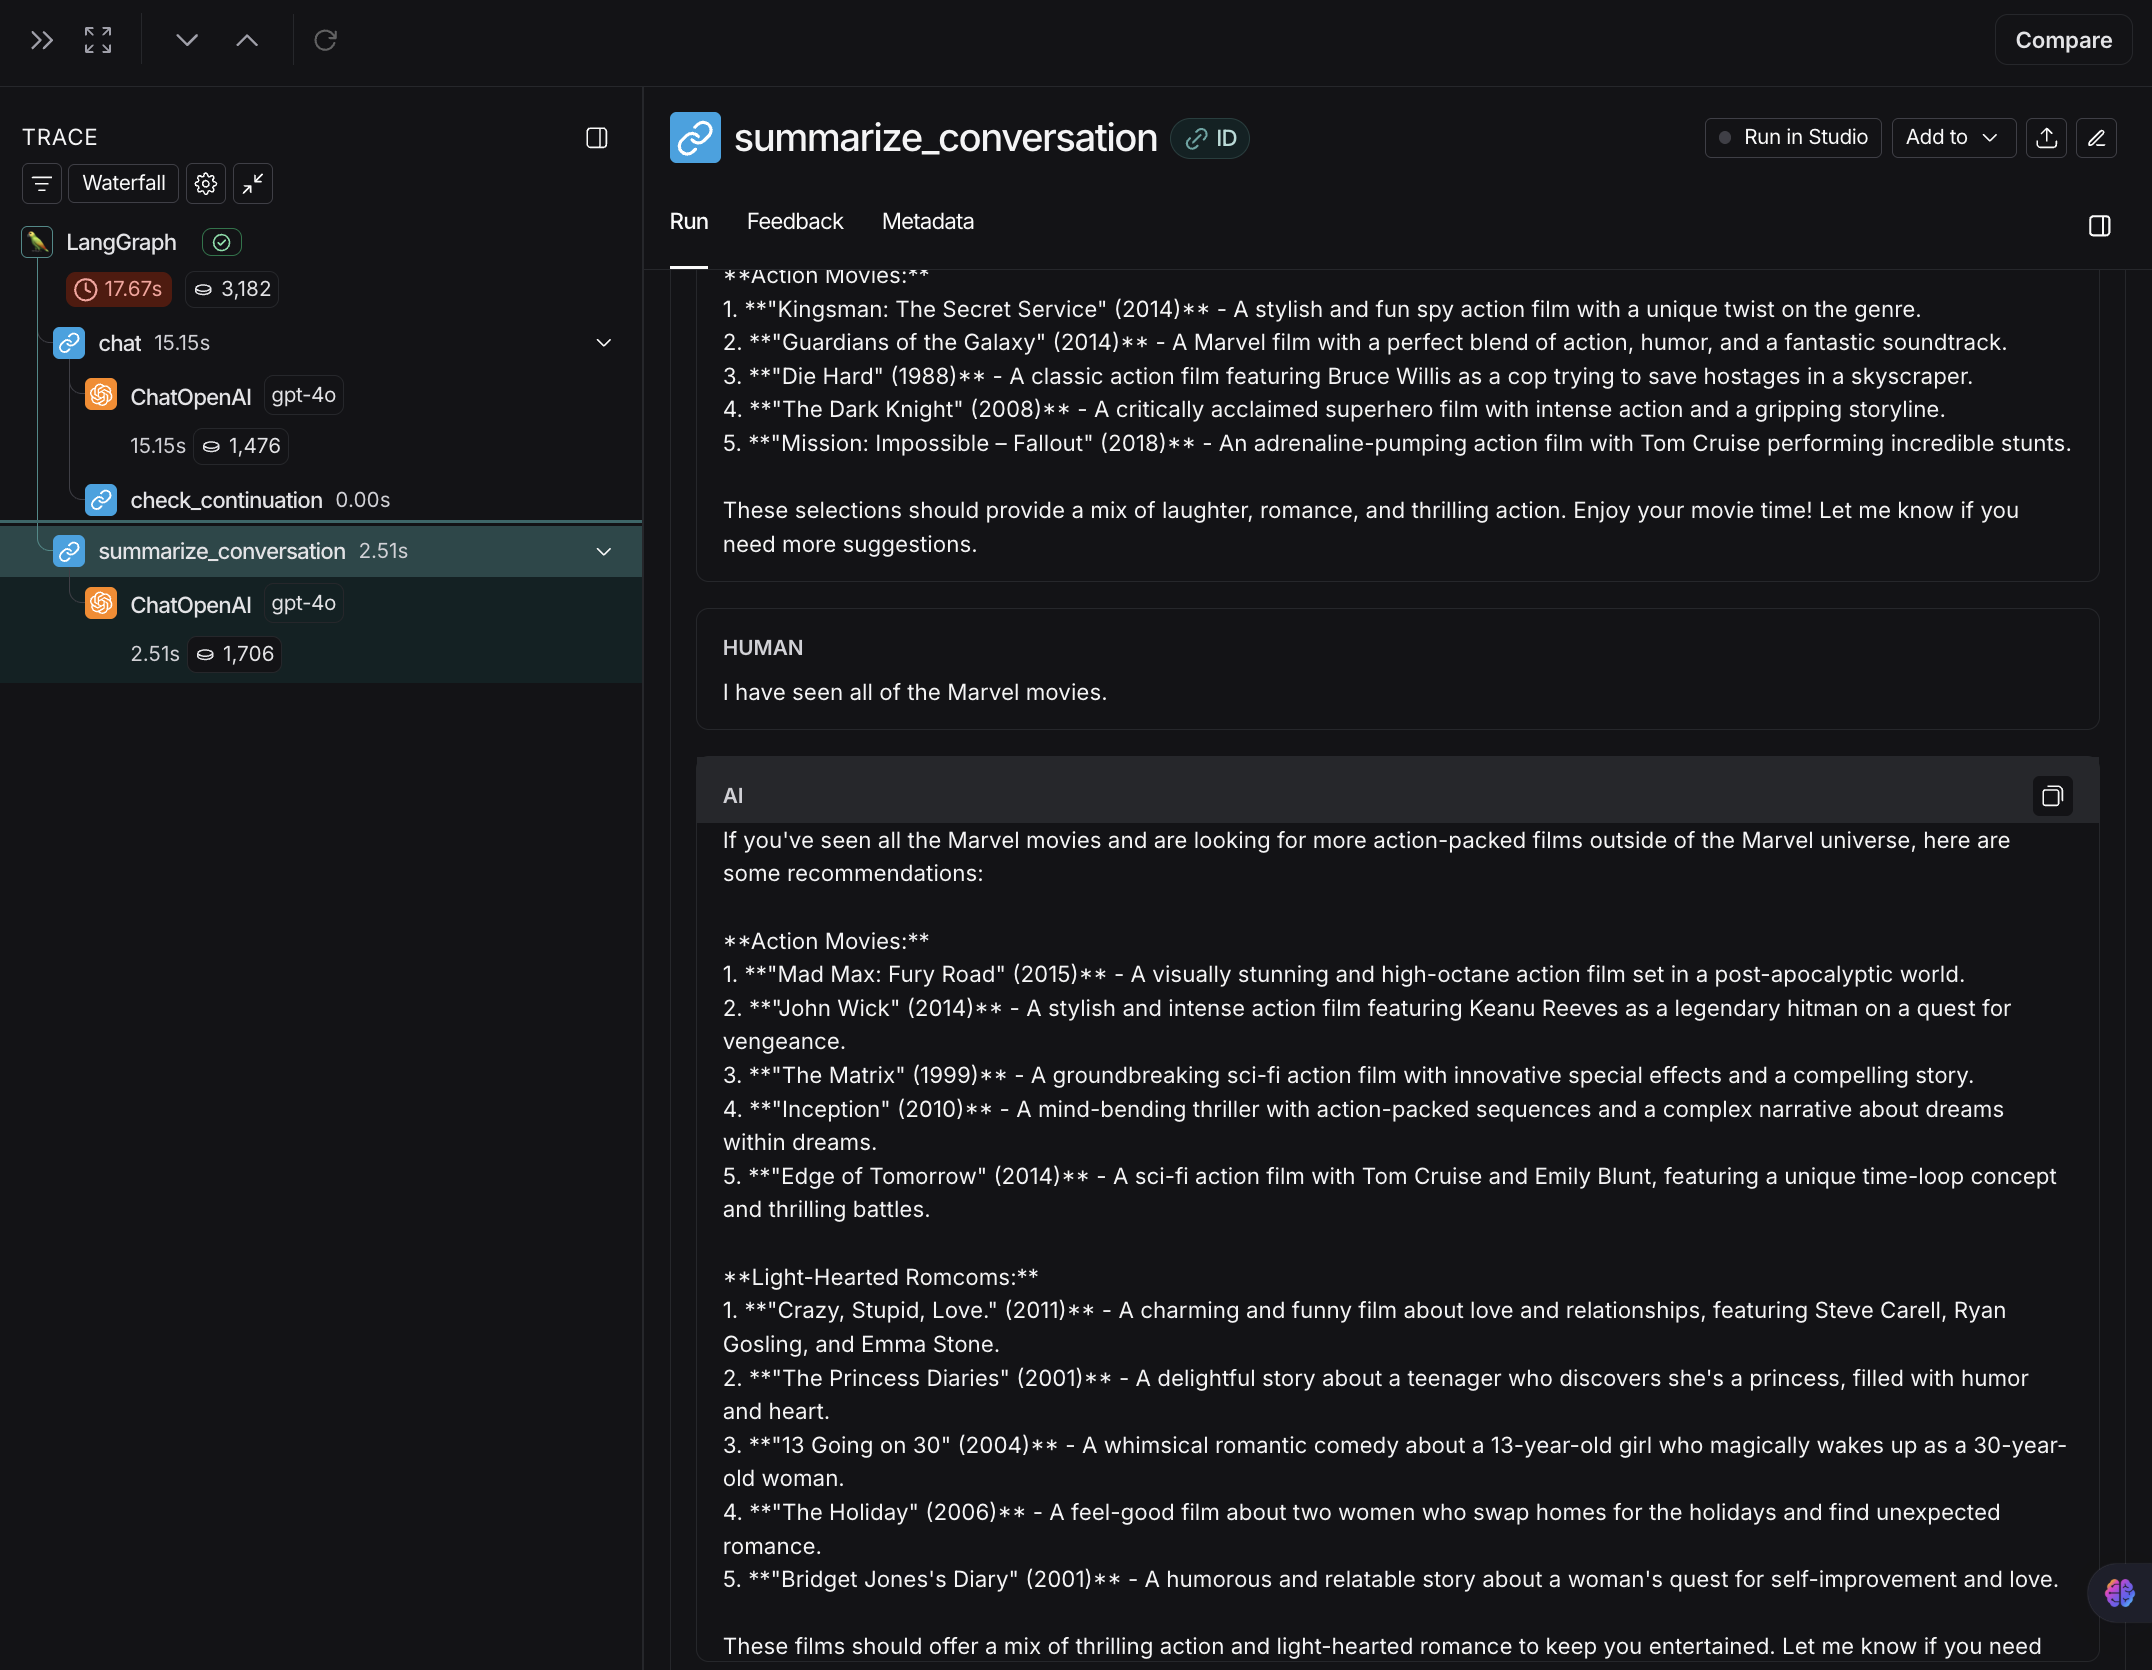

In [ ]:
# Cell 19: Thread 8, Message 4
msg_input = HumanMessage(content="I need to select 4 movies for the weekend to watch with my boyfriend.")
result = graph.invoke({"messages": [msg_input]}, cfg_new)
for msg in result['messages'][-1:]:
    msg.pretty_print()



================================== Ai Message ==================================

That sounds like a fun weekend plan! Here's a mix of action and romantic comedies that you and your boyfriend might enjoy:

1. **"John Wick" (2014)** - For an action-packed experience, this film offers intense sequences and a gripping storyline with Keanu Reeves as the iconic hitman.

2. **"Crazy, Stupid, Love." (2011)** - A charming romantic comedy with a great ensemble cast, including Steve Carell and Ryan Gosling, that balances humor and heart.

3. **"Mad Max: Fury Road" (2015)** - A visually stunning action film with non-stop thrills and an engaging post-apocalyptic setting.

4. **"The Holiday" (2006)** - A feel-good romantic comedy about two women swapping homes for the holidays, leading to unexpected romance and heartwarming moments.

This selection provides a nice balance of action and romance, ensuring there's something for both of you to enjoy. Let me know if you need any more suggestions or adju

In [ ]:
# Cell 20: Thread 8, Message 5
msg_input = HumanMessage(content="suggest something which is not boring ")
result = graph.invoke({"messages": [msg_input]}, cfg_new)
for msg in result['messages'][-1:]:
    msg.pretty_print()



================================== Ai Message ==================================

Absolutely! Here are four engaging and entertaining movies that should keep you and your boyfriend thoroughly entertained:

1. **"Guardians of the Galaxy" (2014)** - Even though it's part of the Marvel universe, this film stands out with its humor, unique characters, and an awesome soundtrack. It's a fun, action-packed space adventure.

2. **"Baby Driver" (2017)** - A stylish and fast-paced action film with a killer soundtrack. It follows a getaway driver who relies on music to be the best in the business.

3. **"The Grand Budapest Hotel" (2014)** - A quirky and visually stunning comedy by Wes Anderson, filled with eccentric characters and a captivating storyline.

4. **"Scott Pilgrim vs. the World" (2010)** - A highly entertaining and visually inventive film that combines romance, comedy, and action, as Scott Pilgrim battles his new girlfriend's seven evil exes.

These films are known for their engaging 

# VERIFICATION OF INDEFINITE MEMORY STORAGE LOCALLY

## i deleted these threads 5 and 1 from my notebook but it still prints thier history even after resatrting the kernel this shows has them saved in the memory, it shows that they were saved indefinitely

In [14]:
config = {"configurable": {"thread_id": "5"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='How many classes compete in the race?', additional_kwargs={}, response_metadata={}, id='301cc5e1-d3ff-4ac2-9793-8b4332f7c2f3'), AIMessage(content="The Rolex 24 at Daytona features multiple classes of cars competing simultaneously, each with its own set of regulations and specifications. As of recent years, the race typically includes the following classes:\n\n1. **GTP (Grand Touring Prototype):** This is the top class, featuring the fastest and most technologically advanced prototype cars. It replaced the DPi class and includes hybrid technology, with manufacturers like Acura, Cadillac, and Porsche participating.\n\n2. **LMP2 (Le Mans Prototype 2):** This class features slightly less powerful prototype cars compared to GTP. It's a cost-capped class designed to encourage privateer teams to compete.\n\n3. **LMP3 (Le Mans Prototype 3):** A more entry-level prototype class, LMP3 cars are less powerful and less expensive than LMP2, pr

In [15]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='642c7013-5d9e-4688-8598-a2cd85ee3d72'), AIMessage(content="Your name is Rishit. If there's anything specific you'd like to discuss or any questions you have, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 471, 'total_tokens': 499, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb3c3cb84d', 'id': 'chatcmpl-CTtr3lHIqq0iQGPYtevBCbt3cf4KW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--073b1539-dbf8-46f3-ae29-aab888939b80-0', usage_metadata={'input_tokens': 471, 'output_tokens': 28, 'total_tokens